# Generate .csv files for CNN

## Imports and Constants

In [1]:
from itertools import combinations

import numpy as np
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

# Label resolution of angles
RESOLUTION = 10

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

# Number of microphones
MICS_NUMBER = 2
MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

## Utils

In [2]:
def plot_cm(y_true, y_pred, class_names, font_scale=0.8):
    cm = confusion_matrix(y_true, y_pred, normalize='true')    
    fig, ax = plt.subplots(figsize=(24, 20)) 
    ax = sns.heatmap(cm, annot=True, fmt=".3f", ax=ax)

    plt.ylabel('Actual', fontsize=30)
    plt.xlabel('Predicted', fontsize=30)
    ax.set_xticklabels(class_names, fontsize=24)
    ax.set_yticklabels(class_names, rotation=0, fontsize=24)
    plt.show()
    
    
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (360 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

In [3]:
def one_hot_encode(encoder, y_train, y_test):    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test


def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test

In [4]:
df_train = pd.read_csv('../training_data/azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/azimuth_test_dataset.csv', index_col=[0])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

In [5]:
# X_ holds (len(df), len(timestep)), y_ hols(len(df), [0..0] of #angle values; 1 when angle occurs)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9918, 21), (9918, 19), (9918, 21), (9918, 19))

## CNN

In [6]:
# Fit model
epochs, batch_size, verbose = 20, 32, 1

def create_simple_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features), padding='same'))
    model.add(Flatten())   # 1D array
    model.add(Dense(n_outputs, activation='softmax'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_test, y_test))
    
    return model, history

In [7]:
# Fit model
epochs, batch_size, verbose = 20, 32, 1

def create_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features), padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())   # 1D array
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_test, y_test))
    
    return model, history

In [8]:
model, history = create_simple_model(X_train, y_train)
np.save('../models/history_simple.npy', history.history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 32)            96        
                                                                 
 flatten (Flatten)           (None, 672)               0         
                                                                 
 dense (Dense)               (None, 19)                12787     
                                                                 
Total params: 12,883
Trainable params: 12,883
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
310/310 [==============================] - 2s 4ms/step - loss: 1.2844 - accuracy: 0.8160 - val_loss: 0.3585 - val_accuracy: 0.9295
Epoch 2/20
310/310 [==============================] - 1s 3ms/step - loss: 0.2738 - accuracy: 0.9340 - val_loss: 0.2223 - val_accuracy: 0.9446
Epoch 3/20
310/310 [============

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 32)            96        
                                                                 
 flatten (Flatten)           (None, 672)               0         
                                                                 
 dense (Dense)               (None, 19)                12787     
                                                                 
Total params: 12,883
Trainable params: 12,883
Non-trainable params: 0
_________________________________________________________________


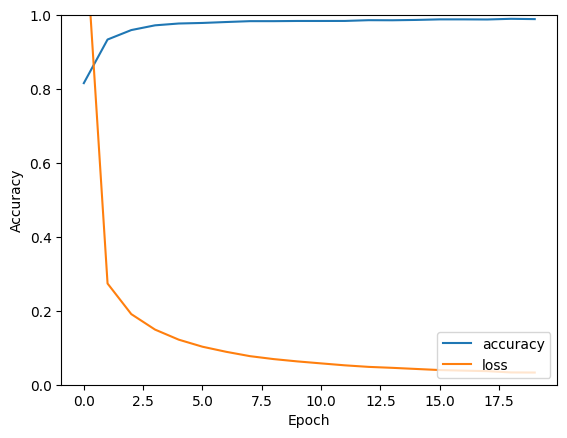

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

310/310 [==============================] - 1s 1ms/step


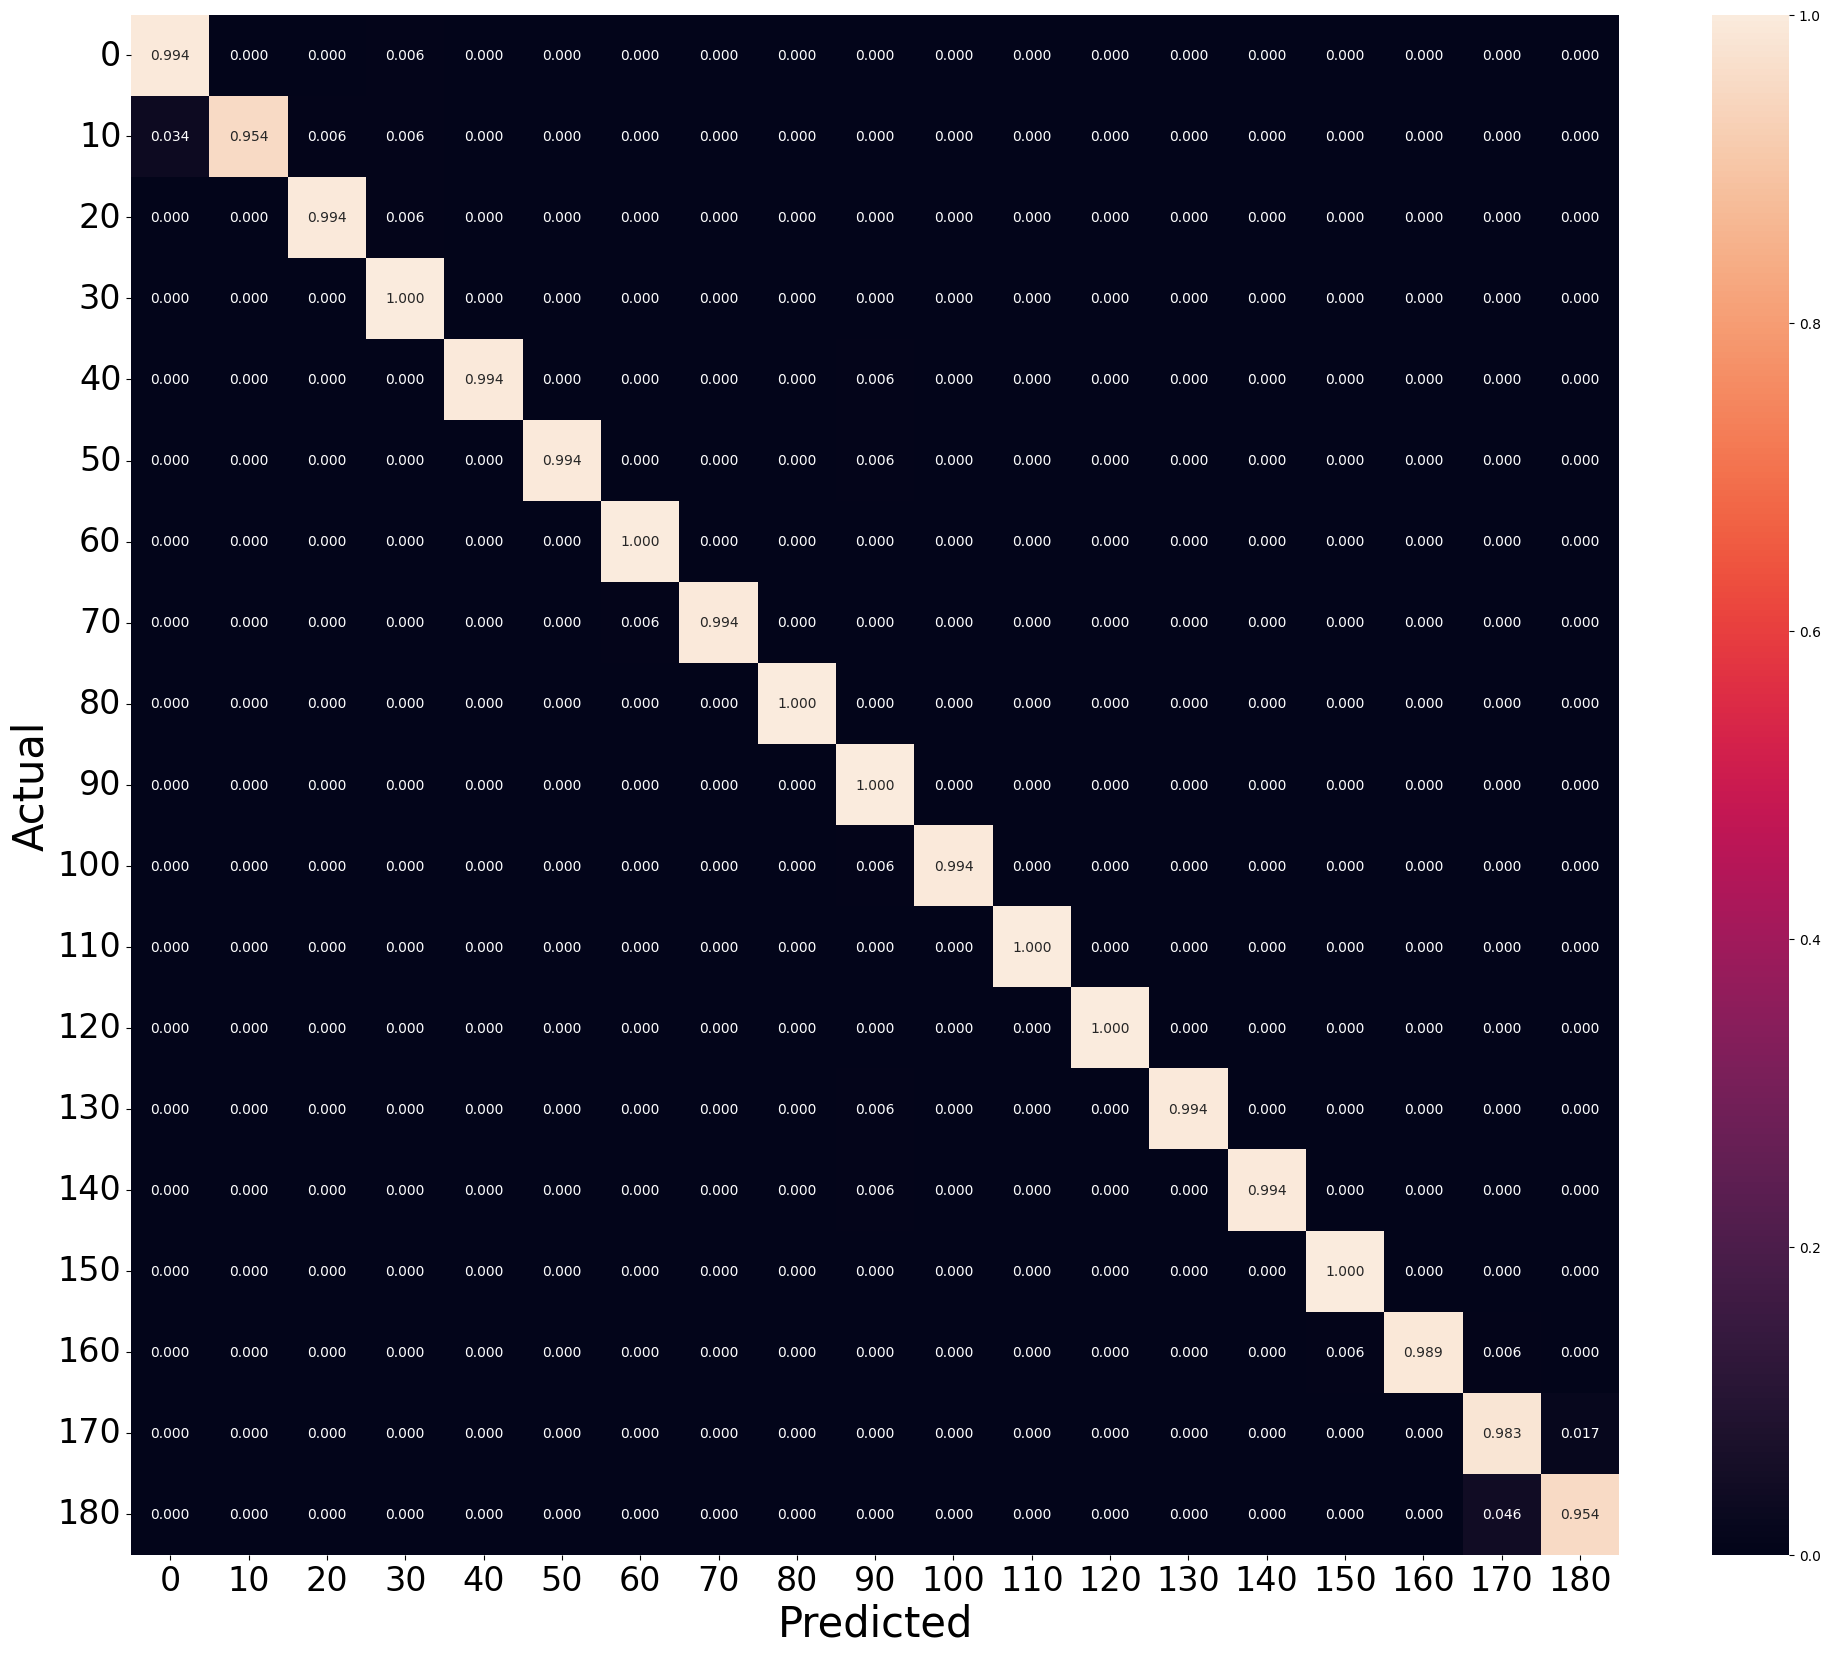

Accuracy: 0.991
RMSE: 1.889


In [11]:
# Test model
# Get more test sets
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

y_pred_nn = model.predict(X_test)
y_pred_nn = encoder.inverse_transform(y_pred_nn)
y_true_nn = encoder.inverse_transform(y_test)
plot_cm(y_true_nn, y_pred_nn, np.unique(y_true_nn))
print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

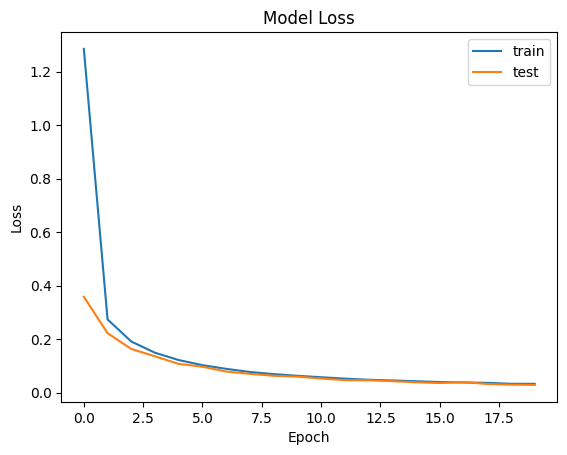

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()